In [1]:
import dlc_bci as bci
import torch
from torch.autograd import Variable
from torch import nn
from torch import optim
from torch import Tensor
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading data

In [2]:
train_input , train_target = bci.load ( root = "./ data_bci")

In [3]:
print(str(type(train_input)) , train_input.size())
print ( str(type(train_target)) , train_target.size())
test_input , test_target = bci.load ( root = "./ data_bci " , train = False )
print (str(type(test_input)) , test_input.size())
print (str(type(test_target)) , test_target.size())

train_target = Variable(train_target)
train_input = Variable(train_input)
test_input = Variable(test_input)
test_target = Variable(test_target)

("<class 'torch.FloatTensor'>", torch.Size([316, 28, 50]))
("<class 'torch.LongTensor'>", torch.Size([316]))
("<class 'torch.FloatTensor'>", torch.Size([100, 28, 50]))
("<class 'torch.LongTensor'>", torch.Size([100]))


### Basic features of the data:
** There are 157 positive samples and 159 negative ones. So the dataset is balanced. **

Text(0.5,0,u'time')

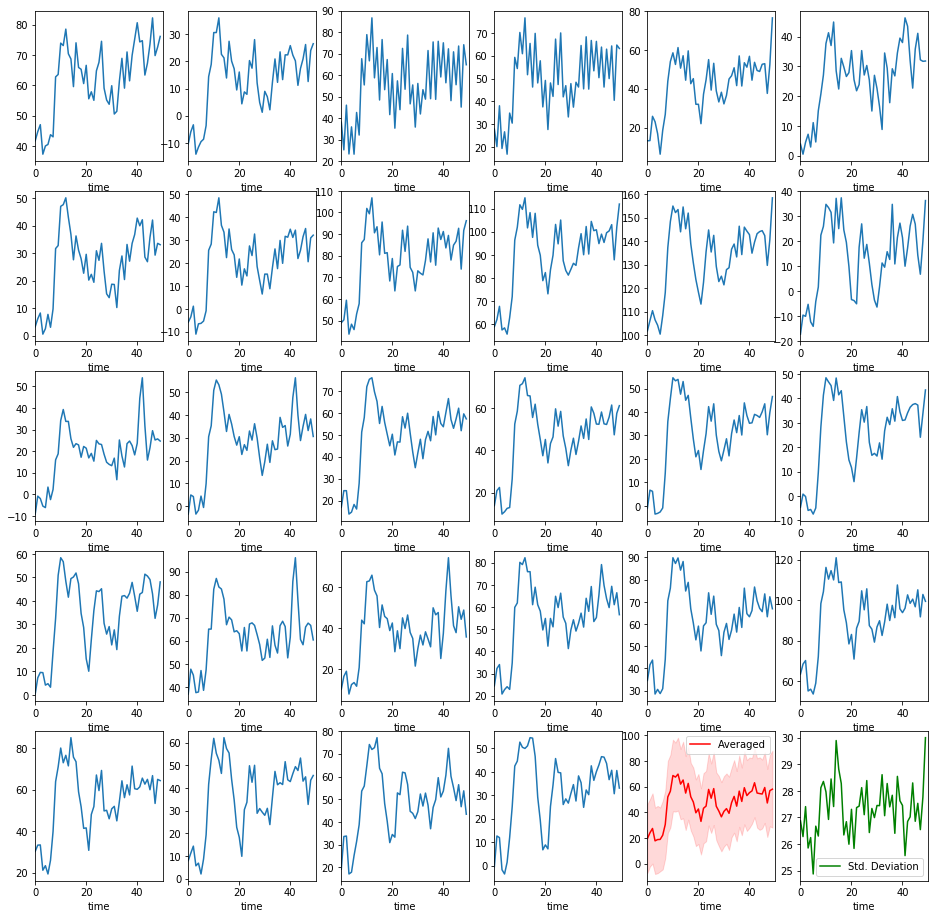

In [19]:
plt.figure(figsize=(16,16))
for i in range(28):
    plt.subplot(5,6,1+i)
    plt.plot(range(50),train_input[0,i,:].data.numpy())
    plt.xlabel("time")
    plt.xlim(0,50)
plt.subplot(5,6,29)

mean= train_input[0,:,:].mean(dim=0).data.numpy()
std = train_input[0,:,:].std(0).data.numpy()

averaged,= plt.plot(range(50),mean,color='r',label="Averaged")
plt.fill_between(range(50),mean-std,mean+std, alpha=0.15, color='r')
plt.xlim(0,50)
plt.legend(handles=[averaged])
plt.xlabel("time")

plt.subplot(5,6,30)
plt.plot(range(50),std, label='Std. Deviation',color='g')
plt.xlim(0,50)
plt.legend()
plt.xlabel("time")

Different channels have similar signlas, so our first basleine is to average them and treat the averaged signal as 1 channel.

## Usefule functions

In [223]:
# The function computes the accuracy
def accuracy(output,target):
    return (output.float()==target.float()).float().sum()/len(output)

## A simple logistic regression as a baseline

In [48]:
## average over the channels for the logistic regression
train_1 = train_input.mean(dim=1)
test_1 = test_input.mean(dim=1)
train_1.unsqueeze_(dim=1)
test_1.unsqueeze_(dim=1)


Variable containing:
( 0 ,.,.) = 
 -2.2807e+01 -2.5843e+01 -2.0557e+01  ...  -1.8368e+01 -2.4839e+01 -2.3336e+01

( 1 ,.,.) = 
  6.3918e+01  7.1936e+01  6.2250e+01  ...   4.1918e+01  4.2932e+01  4.2332e+01

( 2 ,.,.) = 
  2.9907e+01  3.6454e+01  3.7275e+01  ...   3.2225e+01  2.1889e+01  1.7400e+01
... 

(97 ,.,.) = 
  3.3243e+01  1.8914e+01  2.6257e+01  ...  -1.7071e+01 -2.4182e+01 -2.3114e+01

(98 ,.,.) = 
  3.4329e+01  3.5475e+01  2.3857e+01  ...   2.0664e+01  2.3146e+01  3.0532e+01

(99 ,.,.) = 
  4.3393e+01  4.2725e+01  4.2943e+01  ...   6.6357e+00 -2.4143e+00  1.4239e+01
[torch.FloatTensor of size 100x1x50]

In [64]:
## define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.bias = nn.Parameter(Tensor(2))
        self.fc1 = nn.Linear(50, 2)
    def forward(self, x):
        x = self.fc1(x)
        x = x + self.bias
        return x
net = Net()

In [82]:
### train the model
epoch = 1000
batch_size = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.0000001, momentum=0.9)
for e in range(epoch):
    for b in range(0,train_1.size(0),batch_size):
        input_ = train_1.narrow(0,b,min(batch_size,train_1.size(0)-b))
        target = train_target.narrow(0,b,min(batch_size,train_1.size(0)-b))
        output = net(input_).view(min(batch_size,train_1.size(0)-b),2)
        loss = criterion(output,target)
        net.zero_grad()
        loss.backward()
        optimizer.step()
    if e%50 == 0: # print the loss every 10 epochs
        output = net(test_1).view(-1,2)
        a,predicted_class = output.max(dim=1)
        print(criterion(output,test_target).data[0],accuracy(predicted_class,test_target).data[0])

0.7823699116706848 0.5899999737739563
0.7814819812774658 0.5899999737739563
0.7815091609954834 0.5899999737739563
0.7815142869949341 0.5899999737739563
0.7815107107162476 0.5899999737739563
0.7815003991127014 0.5899999737739563
0.7814875841140747 0.5899999737739563
0.781473696231842 0.5899999737739563
0.7814589142799377 0.5899999737739563
0.7814419269561768 0.5899999737739563
0.7814249396324158 0.5899999737739563
0.7814079523086548 0.5899999737739563
0.7813916206359863 0.5899999737739563
0.7813761830329895 0.5899999737739563
0.7813603281974792 0.5899999737739563
0.781343936920166 0.5899999737739563
0.781327486038208 0.5899999737739563
0.7813106775283813 0.5899999737739563
0.7812960743904114 0.5899999737739563
0.7812789082527161 0.5899999737739563


### Second baseline
In the next baseline, we try to increase the number of datapoints. We treat each channel as a datapoint, i.e., we have 360*28 datapoints in total. We shuffle the data to make the data homogenouse.

In [246]:
train_2 = train_input.view(-1,1,50)
train_target_2 = torch.transpose(train_target.repeat(28,1),1,0).clone().view(-1,1).squeeze(1)
test_2 = test_input.view(-1,1,50)
test_target_2 = torch.transpose(test_target.repeat(28,1),1,0).clone().view(-1,1).squeeze(1)
## Let us shuffle the data
perm = list(range(train_2.size(0)))
np.random.shuffle(perm)
train_2 = train_2[perm,:,:]
train_target_2 = train_target_2[perm]
net = Net()

In [249]:
### train the model
epoch = 100
batch_size = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.000001,momentum = 0.9)
i = 0
for e in range(epoch):
    for b in range(0,train_2.size(0),batch_size):
        input_ = train_2.narrow(0,b,min(batch_size,train_2.size(0)-b))
        target = train_target_2.narrow(0,b,min(batch_size,train_2.size(0)-b))
        output = net(input_).view(min(batch_size,train_2.size(0)-b),2)
        loss = criterion(output,target)
        net.zero_grad()
        loss.backward()
        optimizer.step()
    if e%100 == 0: # print the loss every 10 epochs
        output = net(test_2).view(-1,2)
        a,predicted_class = output.max(dim=1)
        predicted_class = predicted_class.view(-1,28)
        predicted_class = 1*(predicted_class.float().mean(dim=1) > 0.5)
        print(criterion(output,test_target_2).data[0],accuracy(predicted_class,test_target).data[0])

0.7529374361038208 0.6200000047683716


### Let us use convolutional network

In [ ]:
## define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 28 , out_channels = 5 , kernel_size = (1,5) )
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(256, 200)
        self.fc2 = nn.Linear(200, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

net = Net2()